In [1]:
import numpy as np
import pandas as pd

# Step 1: Generate synthetic dataset
np.random.seed(42)
num_samples = 2000  # Number of samples

# Random sensor values simulating piezoelectric breathing signals
sensor_values = np.random.uniform(0.1, 2.5, size=num_samples)

# Assign categories based on sensor value ranges
categories = []
for value in sensor_values:
    if 1.0 <= value <= 1.5:
        categories.append(0)  # Normal
    elif value < 1.0:
        categories.append(1)  # Shallow
    elif value > 1.5 and value <= 2.0:
        categories.append(2)  # Deep
    elif value > 2.0:
        categories.append(3)  # Apnea
    else:
        categories.append(4)  # Irregular

# Create a DataFrame
data = pd.DataFrame({'Sensor Value': sensor_values, 'Category': categories})

# Save the dataset to a CSV file
data.to_csv('piezoelectric_breathing_dataset.csv', index=False)

print("Dataset saved to 'piezoelectric_breathing_dataset.csv'")

Dataset saved to 'piezoelectric_breathing_dataset.csv'


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Load dataset
data = pd.read_csv('piezoelectric_breathing_dataset.csv')

# Preprocess the data
sensor_values = data['Sensor Value'].values
categories = data['Category'].values

# Generate synthetic images based on sensor values
X = np.array([np.full((128, 128, 1), value / 2.5) for value in sensor_values])  # Normalize by max value (2.5)
X = np.repeat(X, 3, axis=-1)  # Convert grayscale to RGB

y = np.array(categories)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Piezoelectric breathing data loaded and preprocessed.")

Piezoelectric breathing data loaded and preprocessed.


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.1798 - loss: 2.0576 - val_accuracy: 0.3550 - val_loss: 1.5137
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3984 - loss: 1.4506 - val_accuracy: 0.3550 - val_loss: 1.4330
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5313 - loss: 1.1128 - val_accuracy: 0.3550 - val_loss: 1.4513
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6036 - loss: 0.9682 - val_accuracy: 0.3550 - val_loss: 1.4740
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6339 - loss: 0.9020 - val_accuracy: 0.3550 - val_loss: 1.4528


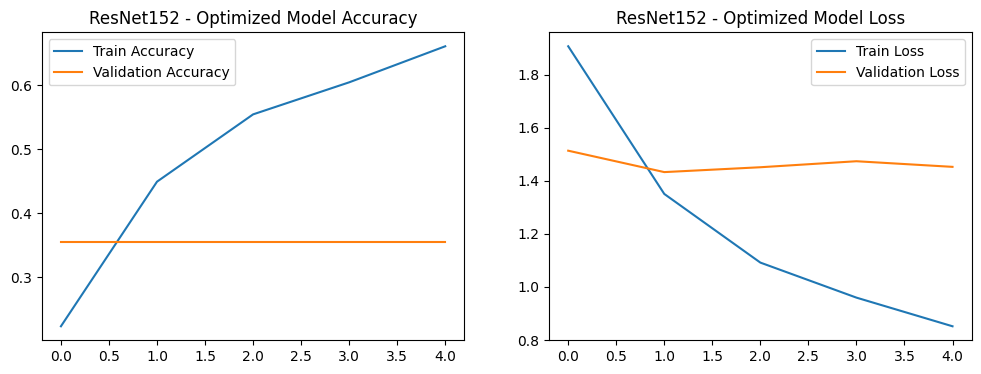

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet152
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.image import resize

# Enable mixed precision training for faster execution
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Step 1: Resize input dataset to match ResNet152 input shape (32x32x3)
X_train = np.array([resize(img, (32, 32)).numpy() for img in X_train])
X_test = np.array([resize(img, (32, 32)).numpy() for img in X_test])

X_train = X_train.astype('float32')  # Ensure correct data type
X_test = X_test.astype('float32')
y_train = y_train.astype('int')
y_test = y_test.astype('int')

# Step 2: Load ResNet152 with optimized settings
base_model = ResNet152(input_shape=(32, 32, 3), include_top=False, weights='imagenet')

# Freeze all layers except the last 5 for fine-tuning
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Define model architecture
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Efficient feature extraction
    layers.Dense(128, activation='relu', dtype='float32'),  # Ensure float32 for stability
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax', dtype='float32')  # 5 classes
])

# Compile model with mixed-precision optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 3: Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=15,  # Reduced epochs for efficiency
    batch_size=64,  # Optimized batch size
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Save the trained model
model.save('piezoelectric_breathing_model_resnet152.h5')

# Step 4: Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet152 - Optimized Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet152 - Optimized Model Loss')
plt.legend()

plt.show()


In [7]:
import tensorflow as tf
import keras

# Define a custom Lambda function if necessary
def custom_lambda_function(x):
    return x  # Replace this with actual transformation if needed

# Define custom objects dictionary
custom_objects = {
    "custom_lambda_function": custom_lambda_function
}

# Load the trained model with custom objects handling
try:
    model = tf.keras.models.load_model(
        'piezoelectric_breathing_model_resnet152.h5',
        custom_objects=custom_objects
    )
    print("Model loaded successfully!")
except Exception as e:
    print("Error loading model:", e)

# Function to predict breathing pattern
def predict_breathing_pattern(sensor_value):
    # Normalize the input sensor value
    sensor_value = (sensor_value - sensor_value.min()) / (sensor_value.max() - sensor_value.min())

    # Reshape for model input
    sensor_value = sensor_value.reshape(1, sensor_value.shape[0], 1)

    # Predict the class
    prediction = model.predict(sensor_value)
    return prediction



Error loading model: Unknown layer: 'Cast'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


In [9]:
import tensorflow as tf
from keras.utils import custom_object_scope

# Define a generic custom object handler
custom_objects = {
    "Cast": tf.keras.layers.Lambda(lambda x: tf.identity(x))  # Identity operation to bypass cast issue
}

# Load the trained ResNet-152 model with custom objects
try:
    with custom_object_scope(custom_objects):
        model = tf.keras.models.load_model('piezoelectric_breathing_model_resnet152.h5')
    print("ResNet-152 model loaded successfully!")
except Exception as e:
    print("Error loading ResNet-152 model:", e)


Error loading ResNet-152 model: 'function'


In [10]:
import tensorflow as tf
from keras.utils import custom_object_scope

# Define the custom Cast layer (Lambda workaround)
custom_objects = {
    "Cast": tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32))
}

# Load the trained ResNet-152 model with custom objects
try:
    with custom_object_scope(custom_objects):
        model = tf.keras.models.load_model('piezoelectric_breathing_model_resnet152.h5')
    print("ResNet-152 model loaded successfully!")
except Exception as e:
    print("Error loading ResNet-152 model:", e)


Error loading ResNet-152 model: 'function'


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import numpy as np

# Generate predictions for the test dataset using ResNet-152 model
y_pred_resnet = model.predict(X_test)
y_pred_classes_resnet = np.argmax(y_pred_resnet, axis=1)  # Get the predicted class indices

# Confusion matrix
conf_matrix_resnet = confusion_matrix(y_test, y_pred_classes_resnet)

# Precision, Recall, and F1 Score
precision_resnet = precision_score(y_test, y_pred_classes_resnet, average='weighted')
recall_resnet = recall_score(y_test, y_pred_classes_resnet, average='weighted')
f1_resnet = f1_score(y_test, y_pred_classes_resnet, average='weighted')

# Get the unique class labels present in y_test
unique_classes = np.unique(y_test)
target_names = ['Normal', 'Shallow', 'Deep', 'Apnea', 'Irregular'][:len(unique_classes)]

# Print metrics for ResNet-152
print("Confusion Matrix (ResNet-152):")
print(conf_matrix_resnet)

print("\n ResNet-152 - Classification Report:")
print(classification_report(y_test, y_pred_classes_resnet, target_names=target_names))

print(f"ResNet-152 Precision: {precision_resnet:.4f}")
print(f"ResNet-152 Recall: {recall_resnet:.4f}")
print(f"ResNet-152 F1 Score: {f1_resnet:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step  
Confusion Matrix (ResNet-152):
[[  0  86   0   0]
 [  0 142   0   0]
 [  0  81   0   0]
 [  0  91   0   0]]

 ResNet-152 - Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        86
     Shallow       0.35      1.00      0.52       142
        Deep       0.00      0.00      0.00        81
       Apnea       0.00      0.00      0.00        91

    accuracy                           0.35       400
   macro avg       0.09      0.25      0.13       400
weighted avg       0.13      0.35      0.19       400

ResNet-152 Precision: 0.1260
ResNet-152 Recall: 0.3550
ResNet-152 F1 Score: 0.1860


C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

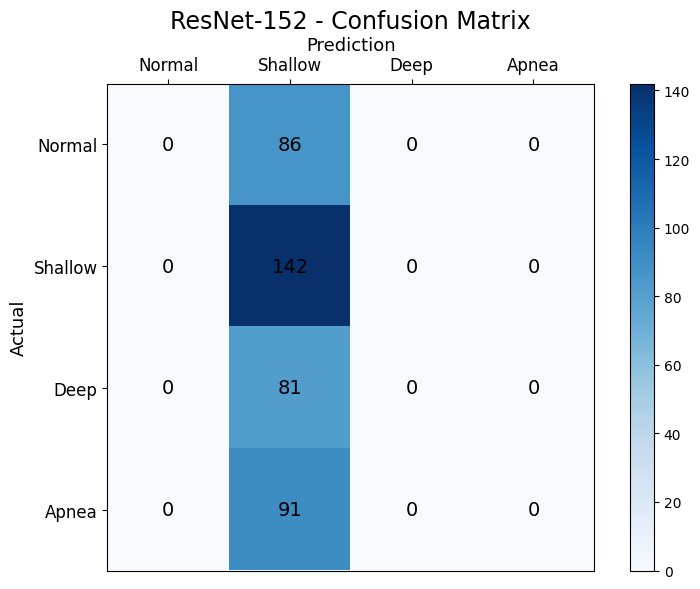

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Generate confusion matrix for ResNet-152
cm_resnet = confusion_matrix(y_test, y_pred_classes_resnet)

# Define class labels dynamically based on unique classes in y_test
unique_classes = np.unique(y_test)
target_names = ['Normal', 'Shallow', 'Deep', 'Apnea', 'Irregular'][:len(unique_classes)]

# Plot confusion matrix using matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm_resnet, cmap='Blues')  # Use the 'Blues' colormap
fig.colorbar(cax)

# Annotate the confusion matrix with the counts
for (i, j), value in np.ndenumerate(cm_resnet):
    ax.text(j, i, f'{value}', ha='center', va='center', color='black', fontsize=14)

# Set axis labels and ticks
ticks = range(len(target_names))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(target_names, fontsize=12)
ax.set_yticklabels(target_names, fontsize=12)

# Move x-axis labels to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Set axis labels and title
ax.set_xlabel('Prediction', fontsize=13)
ax.set_ylabel('Actual', fontsize=13)
plt.title('ResNet-152 - Confusion Matrix', fontsize=17)

# Show the plot
plt.tight_layout()
plt.show()
